In [161]:
import pandas as pd

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [162]:
data = pd.read_csv('df_treated.csv')
data.head()

,DATE,TIME,TREATED WATER PRODUCTION IN m3/h,REMARKS
0,2021-12-01,01:00:00,3397.39,No Remarks
1,2021-12-01,02:00:00,3378.46,No Remarks
2,2021-12-01,03:00:00,3392.56,No Remarks
3,2021-12-01,04:00:00,3402.36,No Remarks
4,2021-12-01,05:00:00,3394.38,No Remarks


In [163]:
data.shape

(21169, 4)

In [164]:
data.isna().sum()

DATE                                0
TIME                                0
TREATED WATER PRODUCTION IN m3/h    0
REMARKS                             0
dtype: int64

In [165]:
mean = data['TREATED WATER PRODUCTION IN m3/h'].mean()
std_dev = data['TREATED WATER PRODUCTION IN m3/h'].std()

# Calculate lower and upper bounds using Z-score method
lower_limit = mean - 3 * std_dev  
upper_limit = mean + 3 * std_dev 

# Identify outliers
outliers_before = data[(data['TREATED WATER PRODUCTION IN m3/h'] < lower_limit) | (data['TREATED WATER PRODUCTION IN m3/h'] > upper_limit)]

# Print outliers before ffill
print(f"Lower Limit: {lower_limit}")
print(f"Upper Limit: {upper_limit}")
print('No. of outliers before ffill:', len(outliers_before))
print(outliers_before)
print("\n")

# Forward fill outliers
data.loc[outliers_before.index, 'TREATED WATER PRODUCTION IN m3/h'] = 0
data['TREATED WATER PRODUCTION IN m3/h'] = data['TREATED WATER PRODUCTION IN m3/h'].ffill()

# Identify outliers after ffill
outliers_after = data[(data['TREATED WATER PRODUCTION IN m3/h'] < lower_limit) | (data['TREATED WATER PRODUCTION IN m3/h'] > upper_limit)]

# Print outliers after ffill
print('No. of outliers after ffill:', len(outliers_after))
print(outliers_after)
print("\n")

Lower Limit: -2326.799533870654
Upper Limit: 8089.771949194949
No. of outliers before ffill: 14
             DATE      TIME  TREATED WATER PRODUCTION IN m3/h     REMARKS
2038   2022-02-23  23:00:00                          34842.45  No Remarks
2936   2022-04-02  09:00:00                          35447.16  No Remarks
9598   2023-01-04  22:00:00                          23538.51  No Remarks
11386  2023-03-20  10:00:00                         190912.10  No Remarks
12156  2023-04-21  12:00:00                          33508.86  No Remarks
15113  2023-08-22  17:00:00                          32922.21  No Remarks
15985  2023-09-28  01:00:00                          31204.67  No Remarks
16586  2023-10-23  02:00:00                          32259.72  No Remarks
17064  2023-11-11  00:00:00                          60401.93  No Remarks
19206  2024-02-09  06:00:00                          34282.39  No Remarks
19796  2024-03-04  20:00:00                          33388.57  No Remarks
20862  2024-04-1

In [166]:
data['DATETIME'] = data['DATE']+' '+ data['TIME']
data.head()

,DATE,TIME,TREATED WATER PRODUCTION IN m3/h,REMARKS,DATETIME
0,2021-12-01,01:00:00,3397.39,No Remarks,2021-12-01 01:00:00
1,2021-12-01,02:00:00,3378.46,No Remarks,2021-12-01 02:00:00
2,2021-12-01,03:00:00,3392.56,No Remarks,2021-12-01 03:00:00
3,2021-12-01,04:00:00,3402.36,No Remarks,2021-12-01 04:00:00
4,2021-12-01,05:00:00,3394.38,No Remarks,2021-12-01 05:00:00


In [167]:
data = data[['DATETIME','TREATED WATER PRODUCTION IN m3/h','REMARKS']]
data.head()

,DATETIME,TREATED WATER PRODUCTION IN m3/h,REMARKS
0,2021-12-01 01:00:00,3397.39,No Remarks
1,2021-12-01 02:00:00,3378.46,No Remarks
2,2021-12-01 03:00:00,3392.56,No Remarks
3,2021-12-01 04:00:00,3402.36,No Remarks
4,2021-12-01 05:00:00,3394.38,No Remarks


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21169 entries, 0 to 21168
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DATETIME                          21169 non-null  object 
 1   TREATED WATER PRODUCTION IN m3/h  21169 non-null  float64
 2   REMARKS                           21169 non-null  object 
dtypes: float64(1), object(2)
memory usage: 496.3+ KB


In [169]:
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21169 entries, 0 to 21168
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   DATETIME                          21169 non-null  datetime64[ns]
 1   TREATED WATER PRODUCTION IN m3/h  21169 non-null  float64       
 2   REMARKS                           21169 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 496.3+ KB


In [170]:
data['year'] = data['DATETIME'].dt.year
data["Quarter"] = data.DATETIME.dt.quarter
data=data[data['year'].isin([2022,2023])]

In [171]:
data.set_index('DATETIME',inplace=True)
data

,TREATED WATER PRODUCTION IN m3/h,REMARKS,year,Quarter
DATETIME,,,,
2022-01-01 01:00:00,2414.89,No Remarks,2022,1
2022-01-01 02:00:00,2416.96,No Remarks,2022,1
2022-01-01 03:00:00,1192.99,No Remarks,2022,1
2022-01-01 04:00:00,1209.52,No Remarks,2022,1
2022-01-01 05:00:00,1188.86,No Remarks,2022,1
...,...,...,...,...
2023-12-31 20:00:00,3421.64,No Remarks,2023,4
2023-12-31 21:00:00,3397.65,No Remarks,2023,4
2023-12-31 22:00:00,3412.47,No Remarks,2023,4


In [172]:
data_monthly = data.resample('M')['TREATED WATER PRODUCTION IN m3/h'].mean()
data_monthly = data_monthly.reset_index()
data_monthly = data_monthly.set_index('DATETIME')
data_monthly
# data_monthly.plot()

,TREATED WATER PRODUCTION IN m3/h
DATETIME,
2022-01-31,2508.315081
2022-02-28,2635.043836
2022-03-31,2817.087461
2022-04-30,2607.959444
2022-05-31,2618.444000
2022-06-30,2432.922580
2022-07-31,2077.888991
2022-08-31,2277.840202
2022-09-30,2555.902639


In [212]:
data_monthly=data_monthly.asfreq(freq='M',method='ffill')

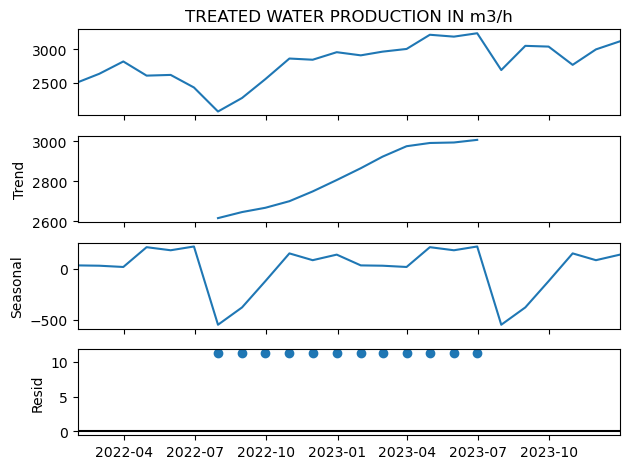

In [216]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_monthly['TREATED WATER PRODUCTION IN m3/h'],model = 'add')
result.plot();

In [217]:
new_df_add=pd.concat([result.seasonal,result.trend,result.resid,result.observed],axis=1)
new_df_add.columns=['seasonality','trend','residual','actual_values']
new_df_add.head()

,seasonality,trend,residual,actual_values
DATETIME,,,,
2022-01-31,31.612251,NaN,NaN,2508.315081
2022-02-28,28.537040,NaN,NaN,2635.043836
2022-03-31,16.213816,NaN,NaN,2817.087461
2022-04-30,209.863966,NaN,NaN,2607.959444
2022-05-31,179.692168,NaN,NaN,2618.444000


In [46]:
data_monthly[data_monthly['TREATED WATER PRODUCTION IN m3/h']==0.0]

,TREATED WATER PRODUCTION IN m3/h
DATETIME,


In [32]:
data_monthly.shape

(24, 1)

In [37]:
class TSA:
    def __init__(self,df):
        self.df = df
        
    def adf_test(self,valcol):
        """
        Pass in a time series and an optional title, returns an ADF report
        """
        result = adfuller(self.df[valcol].dropna(),autolag='AIC') # .dropna() handles differenced data
    
        labels = ['ADF test statistic','p-value','# lags used','# observations']
        out = pd.Series(result[0:4],index=labels)

        for key,val in result[4].items():
            out[f'critical value ({key})']=val
        
        print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
        if result[1] <= 0.05:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")
            state = "Stationary"
        else:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            state = "Non-stationary"
        if state == "Stationary":
            return "Yes"
        else:
            return "No"
    def determine_ARIMA_order(self,valcol):
        stepwise_fit = auto_arima(self.df[valcol], start_p=0, start_q=0,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise
        best_order = stepwise_fit.get_params().get('order')
        print('The best order is {}'.format(best_order))
        return best_order
    def fit_model(self,valcol):
#         if len(self.df[valcol]) > 70:
        train = self.df[valcol][:len(self.df[valcol])-8]
        test = self.df[valcol][len(self.df[valcol])-8:len(self.df[valcol])-4]
        val = self.df[valcol][len(self.df[valcol])-4:]
#         else:
#             train = self.df[valcol][:len(self.df[valcol])-8]
#             test = self.df[valcol][len(self.df[valcol])-8:len(self.df[valcol])-4]
#             val = self.df[valcol][len(self.df[valcol])-4:]
        start = len(train)
        end = len(train)+len(test)-1
#             print('train : {}'.format(train))
#             print('test : {}'.format(test))
        print('start : {}'.format(start))
        print('end : {}'.format(end))
        results = ARIMA(train,order=c1.determine_ARIMA_order(valcol)).fit()
        predictions = results.predict(start=start, end=end)
        predictions_val = results.predict(start=end+1, end=len(train)+len(test)+len(val)-1)
        error1 = mean_squared_error(test, predictions)
        error2 = rmse(test, predictions)
        error3 = mean_absolute_percentage_error(test,predictions)
        accuracy = (1-error3)*100
        print(f'MSE Error: {error1:11.10}')
        print(f'RMSE Error: {error2:11.10}')
        print(f'MAPE Error: {error3:11.10}')
        print(f'Accuracy: {accuracy:11.10}')
#         return start, len(test)
        model_results = {"Model":"ARIMA","Stationary": c1.adf_test(valcol),"X_train": str(len(train))+" Weeks", "X_test": str(len(test))+" Weeks", "X_validation": str(len(val))+" Weeks", "ARIMA_order": c1.determine_ARIMA_order(valcol), "MSE": error1,"RMSE": error2,"MAPE":error3, "Accuracy":((1-error3)*100).round(0)}
#         with open('TSA_AQI_model_result_new.json','a') as f:
#             f.write(str(model_results)+',')
#             f.close()
        return predictions_val
        
            
    def full_data_model(self,valcol):
        results = ARIMA(self.df[valcol],order=c1.determine_ARIMA_order(valcol)).fit()
#         if len(self.df[valcol]) > 70:
        fcast = results.predict(len(self.df), len(self.df)+3,typ='levels').round(2)
#         else:
#             fcast = results.predict(len(self.df), len(self.df)+3,typ='levels').round(2)
#         ax = self.df[valcol].plot(legend=True,figsize=(12,6))
#         fcast.plot(legend=True)
        print(fcast)
#         error_rmse = rmse(self.df[valcol],fcast[0:len(self.df)])
#         error_mse = mean_squared_error(self.df[valcol],fcast[0:len(self.df)])
        DF = pd.DataFrame(self.df[valcol])
        DF['Type'] = 'Actual'
#         DF = DF.reset_index()
        DF_fcast = pd.DataFrame(fcast)
        DF_fcast['Type'] = 'Predicted'
        DF_fcast = DF_fcast.rename(columns={'predicted_mean':valcol})
        final_DF = pd.concat([DF,DF_fcast])
        final_DF = final_DF.reset_index()
#         DF_fcast = DF_fcast.rename(columns={'predicted_mean':'Predicted', 'index':'DateTime'})
        DF_val = pd.DataFrame(c1.fit_model(valcol))
        DF_val = DF_val.reset_index()
        DF_val = DF_val.rename(columns={'index':'Date','predicted_mean':'Validation'})
        final_DF = final_DF.rename(columns={'index':'Date'})
        print(DF_val)
        print(final_DF)
#         final_DF =  final_DF.merge(DF_val, on='DateTime',how='outer')
        final_DF =  final_DF.merge(DF_val, on='Date',how='outer')
        final_DF['Date'] = final_DF['Date'].astype('str')
        print(final_DF)
        
#         final_DF.to_json('/Users/syaminiv/Library/CloudStorage/OneDrive-BayesianWaysLLP/Documents/SiAP_ML_Application/Final_Notebooks/June2023/JSON/TSA_withval_Zone_{}.json'.format(item),orient='records')

c1 = TSA(data_monthly)
c1.adf_test("TREATED WATER PRODUCTION IN m3/h")
c1.determine_ARIMA_order("TREATED WATER PRODUCTION IN m3/h")
c1.fit_model("TREATED WATER PRODUCTION IN m3/h")
c1.full_data_model("TREATED WATER PRODUCTION IN m3/h")

ADF test statistic      -1.870615
p-value                  0.346008
# lags used              0.000000
# observations          28.000000
critical value (1%)     -3.688926
critical value (5%)     -2.971989
critical value (10%)    -2.625296
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
The best order is (0, 1, 0)
start : 21
end : 24
The best order is (0, 1, 0)
MSE Error: 21567.48132
RMSE Error: 146.8587121
MAPE Error: 0.03605443756
Accuracy: 96.39455624
ADF test statistic      -1.870615
p-value                  0.346008
# lags used              0.000000
# observations          28.000000
critical value (1%)     -3.688926
critical value (5%)     -2.971989
critical value (10%)    -2.625296
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


The best order is (0, 1, 0)
The best order is (0, 1, 0)
2024-05-31    3161.14
2024-06-30    3161.14
2024-07-31    3161.14
2024-08-31    3161.14
Freq: M, Name: predicted_mean, dtype: float64
start : 21
end : 24


/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


The best order is (0, 1, 0)
MSE Error: 21567.48132
RMSE Error: 146.8587121
MAPE Error: 0.03605443756
Accuracy: 96.39455624
ADF test statistic      -1.870615
p-value                  0.346008
# lags used              0.000000
# observations          28.000000
critical value (1%)     -3.688926
critical value (5%)     -2.971989
critical value (10%)    -2.625296
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


The best order is (0, 1, 0)
        Date   Validation
0 2024-01-31  3048.014247
1 2024-02-29  3048.014247
2 2024-03-31  3048.014247
3 2024-04-30  3048.014247
         Date  TREATED WATER PRODUCTION IN m3/h       Type
0  2021-12-31                       2599.089059     Actual
1  2022-01-31                       2508.315081     Actual
2  2022-02-28                       2635.043836     Actual
3  2022-03-31                       2817.087461     Actual
4  2022-04-30                       2607.959444     Actual
5  2022-05-31                       2618.444000     Actual
6  2022-06-30                       2432.922580     Actual
7  2022-07-31                       2077.888991     Actual
8  2022-08-31                       2277.840202     Actual
9  2022-09-30                       2555.902639     Actual
10 2022-10-31                       2860.541089     Actual
11 2022-11-30                       2842.808708     Actual
12 2022-12-31                       2954.207396     Actual
13 2023-01-31   

In [14]:
# from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs

# load lynx
# lynx = load_lynx()

# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(data_monthly,m=12,
            test='ch')  # -> 0
D
# or use the OCSB test (by default)
# nsdiffs(lynx,
#         m=10,
#         max_D=12,
#         test='ocsb')  # -> 0


0

### TSA class with seasonality

In [114]:
from pmdarima.arima.utils import nsdiffs
class TSA_seasonal:
    def __init__(self, df):
        self.df = df

    def adf_test(self, valcol):
        """
        Pass in a time series and an optional title, returns an ADF report
        """
        result = adfuller(self.df[valcol].dropna(), autolag='AIC')  # .dropna() handles differenced data

        labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
        out = pd.Series(result[0:4], index=labels)
        print(out.to_string())

        for key, val in result[4].items():
            out[f'critical value ({key})'] = val

        if result[1] <= 0.05:
            state = "Stationary"
        else:
            state = "Non-stationary"
        print("state",state)
        return state
    
    def find_D(self, valcol):
        # Estimate number of seasonal differences using a Canova-Hansen test
        D = nsdiffs(self.df[valcol], m=12, test='ch')
        return D
    

    def determine_SARIMA_order(self, valcol):
        D = self.find_D(valcol)
        stepwise_fit = auto_arima(self.df[valcol], seasonal=True, m=2,
                               start_p=0, start_q=0,
#                               start_P=0, start_Q=0,
                                  D=D,
                                  error_action='ignore',  # we don't want to know if an order does not work
                                  suppress_warnings=True,  # we don't want convergence warnings
                                  stepwise=True)  # set to stepwise
        best_order = stepwise_fit.get_params().get('order')
        best_seasonal_order = stepwise_fit.get_params().get('seasonal_order')
        print('The best seasonal order is {}'.format(best_seasonal_order))
        print('The best order is {}'.format(best_order))
        return best_order, best_seasonal_order


    def fit_model(self, valcol):
    # Split the data into train, test, and validation sets
        train = self.df[valcol][:len(self.df[valcol]) - 8]
        test = self.df[valcol][len(self.df[valcol]) - 8:len(self.df[valcol]) - 4]
        val = self.df[valcol][len(self.df[valcol]) - 4:]

        # Determine the best SARIMA order
        best_order, best_seasonal_order = self.determine_SARIMA_order(valcol)

        # Fit the SARIMA model on the training data
        model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
        results = model.fit()

        # Generate predictions for the test set
        predictions = results.predict(start=len(train), end=len(train) + len(test) - 1)

        # Generate predictions for the validation set
        predictions_val = results.predict(start=len(train) + len(test), end=len(train) + len(test) + len(val) - 1)

        error1 = mean_squared_error(test, predictions)
        error2 = rmse(test, predictions)
        error3 = mean_absolute_percentage_error(test,predictions)
        accuracy = (1-error3)*100
        print(f'MSE Error: {error1:11.10}')
        print(f'RMSE Error: {error2:11.10}')
        print(f'MAPE Error: {error3:11.10}')
        print(f'Accuracy: {accuracy:11.10}')
        return predictions_val

    def full_data_model(self, valcol):
        best_order, best_seasonal_order = self.determine_SARIMA_order(valcol)
        model = SARIMAX(self.df[valcol], order=best_order, seasonal_order=best_seasonal_order)
        results = model.fit()
        fcast = results.forecast(steps=4).round(2)  # Forecast 4 steps ahead
#         print(fcast)
#         fcast_index = pd.date_range(start=self.df.index[-1], periods=4 + 1, freq='M')[1:]  # Assuming monthly data
        DF_fcast = pd.DataFrame({valcol: fcast})
        DF_fcast['Type'] = 'Predicted'
        print(DF_fcast)
        DF = pd.DataFrame(self.df[valcol])
        DF['Type'] = 'Actual'
        # Concatenate original data and forecast data
        combined_DF = pd.concat([DF, DF_fcast])
        combined_DF = combined_DF.reset_index().rename(columns={'index':'Date'})
        print(combined_DF)
        DF_val = pd.DataFrame(c2.fit_model(valcol))
        DF_val = DF_val.reset_index()
        DF_val = DF_val.rename(columns={'index':'Date','predicted_mean':'Validation'})
#         combined_DF = combined_DF.rename(columns={'index':'Date'})
        print(DF_val)
        print(combined_DF)
#         final_DF =  final_DF.merge(DF_val, on='DateTime',how='outer')
        final_DF =  combined_DF.merge(DF_val, on='Date',how='outer')
        final_DF['Date'] = final_DF['Date'].astype('str')
#         print(combined_df)
        return final_DF
    
    
c2 = TSA_seasonal(data_monthly)
c2.adf_test("TREATED WATER PRODUCTION IN m3/h")
# c2.find_D('TREATED WATER PRODUCTION IN m3/h')
c2.determine_SARIMA_order("TREATED WATER PRODUCTION IN m3/h")
c2.fit_model("TREATED WATER PRODUCTION IN m3/h")
c2.full_data_model("TREATED WATER PRODUCTION IN m3/h")

ADF test statistic   -0.606628
p-value               0.869477
# lags used           0.000000
# observations        4.000000
state Non-stationary
The best seasonal order is (0, 0, 0, 2)
The best order is (1, 0, 0)
The best seasonal order is (0, 0, 0, 2)
The best order is (1, 0, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44698D+04    |proj g|=  2.44654D+04

At iterate    5    f=  1.03931D+03    |proj g|=  6.13427D+02

At iterate   10    f=  1.07010D+02    |proj g|=  2.48771D+01

At iterate   15    f=  1.42372D+01    |proj g|=  9.72428D-01

At iterate   20    f=  7.33241D+00    |proj g|=  3.79764D-02

At iterate   25    f=  6.94908D+00    |proj g|=  2.96083D-03

At iterate   30    f=  6.89794D+00    |proj g|=  1.68476D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total numbe

/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shilpa.av/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


ValueError: Prediction must have `end` after `start`.